In [232]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [233]:
plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
playerplay = pd.read_csv('player_play.csv')
tracking_data = pd.read_csv('tracking_week_1.csv')

In [234]:
playerposition = players[['nflId','position']]

In [235]:
filteredtrack = tracking_data[['gameId','playId','frameId','nflId','displayName','x','y','event']]

In [236]:
filteredtrack = pd.merge(
    filteredtrack,
    playerposition,
    how='left',
    left_on=['nflId'],
    right_on=['nflId']
)

In [237]:
filteredtrack = filteredtrack[(filteredtrack['position']=="WR") | (filteredtrack['position']=="TE") | (filteredtrack['position']=="RB")]

In [238]:
motionplayers = playerplay[playerplay['motionSinceLineset']==True]

In [239]:
positions = players[['nflId','position']]

In [240]:
motionplayers = pd.merge(
    motionplayers,
    positions,
    how = "left",
    left_on=['nflId'],
    right_on=['nflId']
)

In [241]:
motionplayers = motionplayers[(motionplayers['position']=="WR") | (motionplayers['position']=="TE") | (motionplayers['position']=="RB")]

In [242]:
motiontracking = pd.merge(
    filteredtrack,
    motionplayers[['gameId','playId','nflId','motionSinceLineset','inMotionAtBallSnap']],
    how="inner",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [243]:
def filter_motion_to_snap(group):
    group = group.sort_values(by='frameId').reset_index(drop=True)
    line_set_indices = group[group['event'] == 'line_set'].index
    snap_indices = group[group['event'] == 'ball_snap'].index
    
    filtered_rows = []
    for start_idx in line_set_indices:
        snap_idx = snap_indices[snap_indices > start_idx].min()
        if pd.notna(snap_idx):
            filtered_rows.extend(group.loc[start_idx:snap_idx].index)
    return group.loc[filtered_rows]
filtered_df = motiontracking.groupby(['gameId', 'playId']).apply(filter_motion_to_snap).reset_index(drop=True)

C:\Users\rschw\AppData\Local\Temp\ipykernel_20660\1614609999.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = motiontracking.groupby(['gameId', 'playId']).apply(filter_motion_to_snap).reset_index(drop=True)


In [244]:
filtered_df[['gameId','playId']].drop_duplicates().shape

(1076, 2)

In [245]:
filtered_df

gameId  playId  frameId    nflId   displayName      x      y  \
0       2022090800      56       76  42489.0  Stefon Diggs  87.02  27.91   
1       2022090800      56       77  42489.0  Stefon Diggs  87.04  28.36   
2       2022090800      56       78  42489.0  Stefon Diggs  87.06  28.82   
3       2022090800      56       79  42489.0  Stefon Diggs  87.07  29.27   
4       2022090800      56       80  42489.0  Stefon Diggs  87.09  29.73   
...            ...     ...      ...      ...           ...    ...    ...   
162169  2022091200    3723      306  52454.0   K.J. Hamler  71.56  39.21   
162170  2022091200    3723      307  52454.0   K.J. Hamler  71.56  39.21   
162171  2022091200    3723      308  52454.0   K.J. Hamler  71.56  39.21   
162172  2022091200    3723      309  52454.0   K.J. Hamler  71.56  39.21   
162173  2022091200    3723      310  52454.0   K.J. Hamler  71.56  39.21   

            event position motionSinceLineset inMotionAtBallSnap  
0        line_set       WR               True              False  
1             NaN       WR               True              False  
2             NaN       WR               True              False  
3             NaN       WR               True              False  
4             NaN       WR               True              False  
...           ...      ...                ...                ...  
162169        NaN       WR               True              False  
162170        NaN       WR               True              False  
162171        NaN       WR               True              False  
162172        NaN       WR               True              False  
162173  ball_snap       WR               True              False  

[162174 rows x 11 columns]

In [246]:
plays_final = plays[["gameId","playId","absoluteYardlineNumber"]]

In [247]:
from math import sqrt

def total_distance(df):
    results = []
    temp_distances = []
    start_index = 0  

    for i in range(len(df) - 1):
        x_diff = df.iloc[i + 1]["x"] - df.iloc[i]["x"]
        y_diff = df.iloc[i + 1]["y"] - df.iloc[i]["y"]
        temp_distances.append(sqrt(x_diff**2 + y_diff**2))
        
     
        if df.iloc[i + 1]["event"] == "line_set":
            if temp_distances: 
                results.append({
                    "playId": df.iloc[start_index]["playId"],
                    "nflId": df.iloc[start_index]["nflId"],
                    "total_distance": sum(temp_distances),
                })
            temp_distances = []  
            start_index = i + 1  

    
    if temp_distances:
        results.append({
            "playId": df.iloc[start_index]["playId"],
            "nflId": df.iloc[start_index]["nflId"],
            "total_distance": sum(temp_distances),
        })

    return pd.DataFrame(results)  


In [248]:
total_distance_final = total_distance(filtered_df)

In [249]:
total_distance_final.head(10)

playId    nflId  total_distance
0      56  42489.0       22.138798
1      80  47857.0       55.299840
2     212  47879.0       21.079664
3     236  52536.0       29.596483
4     299  44881.0       20.693509
5     299  53678.0       10.090079
6     299  43399.0     2736.776968
7     299  53678.0       10.090079
8     299  43399.0     2736.989773
9     299  43399.0     2743.767335

In [250]:
unique_dist_rows = total_distance_final.drop_duplicates(subset=['nflId', 'playId'])

In [251]:
unique_dist_rows.head(10)

playId    nflId  total_distance
0       56  42489.0       22.138798
1       80  47857.0       55.299840
2      212  47879.0       21.079664
3      236  52536.0       29.596483
4      299  44881.0       20.693509
5      299  53678.0       10.090079
6      299  43399.0     2736.776968
10     343  44881.0       14.690872
11     364  44881.0       49.293067
12     393  44881.0       28.820243

In [252]:
filtered_df

gameId  playId  frameId    nflId   displayName      x      y  \
0       2022090800      56       76  42489.0  Stefon Diggs  87.02  27.91   
1       2022090800      56       77  42489.0  Stefon Diggs  87.04  28.36   
2       2022090800      56       78  42489.0  Stefon Diggs  87.06  28.82   
3       2022090800      56       79  42489.0  Stefon Diggs  87.07  29.27   
4       2022090800      56       80  42489.0  Stefon Diggs  87.09  29.73   
...            ...     ...      ...      ...           ...    ...    ...   
162169  2022091200    3723      306  52454.0   K.J. Hamler  71.56  39.21   
162170  2022091200    3723      307  52454.0   K.J. Hamler  71.56  39.21   
162171  2022091200    3723      308  52454.0   K.J. Hamler  71.56  39.21   
162172  2022091200    3723      309  52454.0   K.J. Hamler  71.56  39.21   
162173  2022091200    3723      310  52454.0   K.J. Hamler  71.56  39.21   

            event position motionSinceLineset inMotionAtBallSnap  
0        line_set       WR               True              False  
1             NaN       WR               True              False  
2             NaN       WR               True              False  
3             NaN       WR               True              False  
4             NaN       WR               True              False  
...           ...      ...                ...                ...  
162169        NaN       WR               True              False  
162170        NaN       WR               True              False  
162171        NaN       WR               True              False  
162172        NaN       WR               True              False  
162173  ball_snap       WR               True              False  

[162174 rows x 11 columns]

In [253]:
filtered_df1 = pd.merge(
    filtered_df,
    plays_final[['gameId', 'playId', 'yardlineNumber']],
    how="inner",
    left_on=['gameId', 'playId'],
    right_on=['gameId', 'playId']
)


KeyError: "['yardlineNumber'] not in index"

In [254]:
filtered_df1

gameId  playId  frameId    nflId   displayName      x      y  \
0       2022090800      56       76  42489.0  Stefon Diggs  87.02  27.91   
1       2022090800      56       77  42489.0  Stefon Diggs  87.04  28.36   
2       2022090800      56       78  42489.0  Stefon Diggs  87.06  28.82   
3       2022090800      56       79  42489.0  Stefon Diggs  87.07  29.27   
4       2022090800      56       80  42489.0  Stefon Diggs  87.09  29.73   
...            ...     ...      ...      ...           ...    ...    ...   
162169  2022091200    3723      306  52454.0   K.J. Hamler  71.56  39.21   
162170  2022091200    3723      307  52454.0   K.J. Hamler  71.56  39.21   
162171  2022091200    3723      308  52454.0   K.J. Hamler  71.56  39.21   
162172  2022091200    3723      309  52454.0   K.J. Hamler  71.56  39.21   
162173  2022091200    3723      310  52454.0   K.J. Hamler  71.56  39.21   

            event position motionSinceLineset inMotionAtBallSnap  \
0        line_set       WR               True              False   
1             NaN       WR               True              False   
2             NaN       WR               True              False   
3             NaN       WR               True              False   
4             NaN       WR               True              False   
...           ...      ...                ...                ...   
162169        NaN       WR               True              False   
162170        NaN       WR               True              False   
162171        NaN       WR               True              False   
162172        NaN       WR               True              False   
162173  ball_snap       WR               True              False   

        yardlineNumber  
0                   25  
1                   25  
2                   25  
3                   25  
4                   25  
...                ...  
162169              40  
162170              40  
162171              40  
162172              40  
162173              40  

[162174 rows x 12 columns]

In [255]:
motionstats = (
    filtered_df1.groupby(['gameId', 'playId', 'nflId', 'position'])[['x', 'y']]
    .agg(['first', 'last', 'max', 'min'])
    .reset_index()
)

# Flatten the column structure
motionstats.columns = [
    '_'.join(col).strip('_') if isinstance(col, tuple) else col
    for col in motionstats.columns
]

In [256]:
motionstats

gameId  playId    nflId position  x_first  x_last  x_max  x_min  \
0     2022090800      56  42489.0       WR    87.02   86.24  87.17  86.24   
1     2022090800      80  47857.0       RB    81.74   85.83  85.83  81.72   
2     2022090800     212  47879.0       TE    45.90   46.68  46.68  45.90   
3     2022090800     236  52536.0       WR    37.08   36.79  37.12  36.79   
4     2022090800     299  43399.0       TE    24.11   25.54  25.76  24.09   
...          ...     ...      ...      ...      ...     ...    ...    ...   
1328  2022091200    3382  46109.0       WR    20.79   20.63  20.79  20.63   
1329  2022091200    3491  46096.0       RB    35.99   35.82  36.05  35.82   
1330  2022091200    3553  52423.0       WR    90.40   91.55  91.55  90.15   
1331  2022091200    3596  52423.0       WR    85.43   85.62  86.57  85.43   
1332  2022091200    3723  52454.0       WR    71.85   71.56  73.15  71.54   

      y_first  y_last  y_max  y_min  
0       27.91   43.65  43.67  27.91  
1       39.38   31.54  39.41  28.69  
2       23.83   32.83  32.83  23.83  
3       40.09   35.27  40.09  35.27  
4       23.81   18.99  23.81  18.86  
...       ...     ...    ...    ...  
1328    29.27   33.27  33.27  29.27  
1329    20.99   27.25  27.25  20.99  
1330    33.44   28.83  33.56  28.83  
1331    34.88   16.78  34.88  16.78  
1332    38.56   39.21  39.21  33.32  

[1333 rows x 12 columns]

In [257]:
y_forward_change = (motionstats['y_last'] > motionstats['y_first']) & (motionstats['y_max'] > (motionstats['y_last'] + 1))
y_backward_change = (motionstats['y_last'] <= motionstats['y_first']) & (motionstats['y_min'] < (motionstats['y_last'] - 1))

x_forward_change = (motionstats['x_last'] > motionstats['x_first']) & (motionstats['x_max'] > (motionstats['x_last'] + 1))
x_backward_change = (motionstats['x_last'] <= motionstats['x_first']) & (motionstats['x_min'] < (motionstats['x_last'] - 1))

motionstats['direction_change'] = (y_forward_change | y_backward_change) | (x_forward_change | x_backward_change)



In [258]:
motionstats = pd.merge(
    motionstats,
    playerplay[['gameId','playId','nflId','inMotionAtBallSnap']],
    how="left",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [259]:
final_motionstats = pd.merge(
    motionstats,
    unique_dist_rows[['total_distance','playId','nflId']],
    how="left",
    left_on=['playId','nflId'],
    right_on=['playId','nflId']
)

In [260]:
final_motionstats['total_distance'] = final_motionstats['total_distance'].clip(upper=100)
final_motionstats

gameId  playId    nflId position  x_first  x_last  x_max  x_min  \
0     2022090800      56  42489.0       WR    87.02   86.24  87.17  86.24   
1     2022090800      80  47857.0       RB    81.74   85.83  85.83  81.72   
2     2022090800     212  47879.0       TE    45.90   46.68  46.68  45.90   
3     2022090800     236  52536.0       WR    37.08   36.79  37.12  36.79   
4     2022090800     299  43399.0       TE    24.11   25.54  25.76  24.09   
...          ...     ...      ...      ...      ...     ...    ...    ...   
1328  2022091200    3382  46109.0       WR    20.79   20.63  20.79  20.63   
1329  2022091200    3491  46096.0       RB    35.99   35.82  36.05  35.82   
1330  2022091200    3553  52423.0       WR    90.40   91.55  91.55  90.15   
1331  2022091200    3596  52423.0       WR    85.43   85.62  86.57  85.43   
1332  2022091200    3723  52454.0       WR    71.85   71.56  73.15  71.54   

      y_first  y_last  y_max  y_min  direction_change inMotionAtBallSnap  \
0       27.91   43.65  43.67  27.91             False              False   
1       39.38   31.54  39.41  28.69              True               True   
2       23.83   32.83  32.83  23.83             False               True   
3       40.09   35.27  40.09  35.27             False               True   
4       23.81   18.99  23.81  18.86             False              False   
...       ...     ...    ...    ...               ...                ...   
1328    29.27   33.27  33.27  29.27             False               True   
1329    20.99   27.25  27.25  20.99             False               True   
1330    33.44   28.83  33.56  28.83             False               True   
1331    34.88   16.78  34.88  16.78             False               True   
1332    38.56   39.21  39.21  33.32             False              False   

      total_distance  
0          22.138798  
1          55.299840  
2          21.079664  
3          29.596483  
4         100.000000  
...              ...  
1328       23.669269  
1329       61.233260  
1330       14.006074  
1331       44.163469  
1332       13.929426  

[1333 rows x 15 columns]

In [261]:
final_df = final_motionstats

In [262]:
final_motionstats = final_motionstats.drop_duplicates(subset=['nflId', 'playId'])

In [263]:
final_df = pd.get_dummies(final_motionstats, columns=['position'], prefix='pos', drop_first=True)

In [264]:
final_df

gameId  playId    nflId  x_first  x_last  x_max  x_min  y_first  \
0     2022090800      56  42489.0    87.02   86.24  87.17  86.24    27.91   
1     2022090800      80  47857.0    81.74   85.83  85.83  81.72    39.38   
2     2022090800     212  47879.0    45.90   46.68  46.68  45.90    23.83   
3     2022090800     236  52536.0    37.08   36.79  37.12  36.79    40.09   
4     2022090800     299  43399.0    24.11   25.54  25.76  24.09    23.81   
...          ...     ...      ...      ...     ...    ...    ...      ...   
1328  2022091200    3382  46109.0    20.79   20.63  20.79  20.63    29.27   
1329  2022091200    3491  46096.0    35.99   35.82  36.05  35.82    20.99   
1330  2022091200    3553  52423.0    90.40   91.55  91.55  90.15    33.44   
1331  2022091200    3596  52423.0    85.43   85.62  86.57  85.43    34.88   
1332  2022091200    3723  52454.0    71.85   71.56  73.15  71.54    38.56   

      y_last  y_max  y_min  direction_change inMotionAtBallSnap  \
0      43.65  43.67  27.91             False              False   
1      31.54  39.41  28.69              True               True   
2      32.83  32.83  23.83             False               True   
3      35.27  40.09  35.27             False               True   
4      18.99  23.81  18.86             False              False   
...      ...    ...    ...               ...                ...   
1328   33.27  33.27  29.27             False               True   
1329   27.25  27.25  20.99             False               True   
1330   28.83  33.56  28.83             False               True   
1331   16.78  34.88  16.78             False               True   
1332   39.21  39.21  33.32             False              False   

      total_distance  pos_TE  pos_WR  
0          22.138798   False    True  
1          55.299840   False   False  
2          21.079664    True   False  
3          29.596483   False    True  
4         100.000000    True   False  
...              ...     ...     ...  
1328       23.669269   False    True  
1329       61.233260   False   False  
1330       14.006074   False    True  
1331       44.163469   False    True  
1332       13.929426   False    True  

[1333 rows x 16 columns]

In [ ]:
plays.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [265]:
plays_final = plays[["gameId","playId","absoluteYardlineNumber"]]
plays_final

gameId  playId  absoluteYardlineNumber
0      2022102302    2655                      31
1      2022091809    3698                      18
2      2022103004    3146                      30
3      2022110610     348                      33
4      2022102700    2799                      37
...           ...     ...                     ...
16119  2022110604    1051                      79
16120  2022103005    3492                      35
16121  2022092502    2337                      97
16122  2022091809     719                      57
16123  2022101602    3046                      44

[16124 rows x 3 columns]

In [266]:
final_df = pd.merge(
    final_df,
    plays_final[['gameId', 'playId', 'absoluteYardlineNumber']],
    how="inner",
    left_on=['gameId', 'playId'],
    right_on=['gameId', 'playId']
)

In [267]:
final_df.head(30)

gameId  playId    nflId  x_first  x_last   x_max   x_min  y_first  \
0   2022090800      56  42489.0    87.02   86.24   87.17   86.24    27.91   
1   2022090800      80  47857.0    81.74   85.83   85.83   81.72    39.38   
2   2022090800     212  47879.0    45.90   46.68   46.68   45.90    23.83   
3   2022090800     236  52536.0    37.08   36.79   37.12   36.79    40.09   
4   2022090800     299  43399.0    24.11   25.54   25.76   24.09    23.81   
5   2022090800     299  44881.0    25.77   23.52   25.77   23.52    13.27   
6   2022090800     299  53678.0    24.15   24.60   24.71   24.15    33.90   
7   2022090800     343  44881.0    24.74   24.67   24.79   24.64    17.01   
8   2022090800     364  44881.0    19.39   26.17   26.17   19.35    29.69   
9   2022090800     393  44881.0    49.54   48.82   49.54   48.82    36.98   
10  2022090800     393  47853.0    50.62   46.38   50.62   45.53     8.18   
11  2022090800     438  53678.0    60.41   59.29   60.43   59.29    14.58   
12  2022090800     529  47879.0   103.04  102.95  103.05  102.95    23.99   
13  2022090800     550  42489.0    95.75   95.79   96.25   95.73    44.18   
14  2022090800     569  42489.0    96.93   97.44   97.53   96.85    21.05   
15  2022090800     617  44985.0    76.33   76.70   76.70   76.33    30.15   
16  2022090800     721  42448.0    40.66   40.47   41.05   40.17    21.42   
17  2022090800     721  44985.0    40.43   40.64   42.76   40.36    17.39   
18  2022090800     721  47857.0    44.16   43.79   44.17   43.09    31.98   
19  2022090800     818  47853.0    82.31   86.96   86.96   82.29    39.34   
20  2022090800     896  54528.0    40.27   38.98   40.27   38.89    30.61   
21  2022090800     933  43399.0    48.00   47.00   48.00   46.90    20.11   
22  2022090800     933  44881.0    48.39   49.66   49.66   48.39    35.65   
23  2022090800    1030  44985.0    47.40   46.86   47.52   46.76    30.66   
24  2022090800    1102  42818.0    83.99   83.41   84.17   83.36    10.31   
25  2022090800    1102  44985.0    82.88   83.44   83.70   82.79    21.41   
26  2022090800    1102  47879.0    83.57   83.80   83.87   81.91    35.53   
27  2022090800    1102  52494.0    79.74   79.69   79.74   79.55    32.21   
28  2022090800    1102  52536.0    83.62   84.31   84.33   82.95    17.27   
29  2022090800    1187  43399.0    72.20   71.61   72.67   71.59    32.99   

    y_last  y_max  y_min  direction_change inMotionAtBallSnap  total_distance  \
0    43.65  43.67  27.91             False              False       22.138798   
1    31.54  39.41  28.69              True               True       55.299840   
2    32.83  32.83  23.83             False               True       21.079664   
3    35.27  40.09  35.27             False               True       29.596483   
4    18.99  23.81  18.86             False              False      100.000000   
5    18.81  18.81  13.27             False               True       20.693509   
6    28.96  33.90  28.90             False              False       10.090079   
7    21.17  21.17  16.92             False               True       14.690872   
8    14.66  29.75  14.65             False              False       49.293067   
9    33.54  36.98  33.54             False               True       28.820243   
10   25.85  25.87   8.18             False              False      100.000000   
11   19.88  19.88  14.41             False               True       49.836154   
12   24.52  24.52  23.97             False               True       21.763979   
13   38.71  44.18  38.71             False               True       23.307326   
14   34.99  34.99  21.05             False               True       35.855567   
15   21.53  30.18  21.53             False               True       43.349944   
16   18.39  21.59  17.55             False              False        4.036558   
17   46.86  46.90  17.39              True              False      100.000000   
18   26.53  31.98  26.50             False              False       11.124909   


In [ ]:
def adjust_x_coordinates(row):
 
    adjusted_x_first = abs(row["x_first"] - row["absoluteYardlineNumber"])
    adjusted_x_last = abs(row["x_last"] - row["absoluteYardlineNumber"])
    adjusted_x_max = abs(row["x_max"] - row["absoluteYardlineNumber"])
    adjusted_x_min = abs(row["x_min"] - row["absoluteYardlineNumber"])

   
    return pd.Series([adjusted_x_first, adjusted_x_last, adjusted_x_max, adjusted_x_min])


final_df[['adjusted_x_first', 'adjusted_x_last', 'adjusted_x_max', 'adjusted_x_min']] = final_df.apply(adjust_x_coordinates, axis=1)

final_df[['gameId', 'playId', 'nflId', 'absoluteYardlineNumber', 'x_first', 'x_last', 'x_max', 'x_min',
        'adjusted_x_first', 'adjusted_x_last', 'adjusted_x_max', 'adjusted_x_min',
       'y_first', 'y_last', 'y_max', 'y_min', 'direction_change',
       'inMotionAtBallSnap', 'total_distance', 'pos_TE', 'pos_WR']]



gameId  playId    nflId  absoluteYardlineNumber  x_first  x_last  \
0     2022090800      56  42489.0                      85    87.02   86.24   
1     2022090800      80  47857.0                      79    81.74   85.83   
2     2022090800     212  47879.0                      44    45.90   46.68   
3     2022090800     236  52536.0                      36    37.08   36.79   
4     2022090800     299  43399.0                      27    24.11   25.54   
...          ...     ...      ...                     ...      ...     ...   
1328  2022091200    3382  46109.0                      18    20.79   20.63   
1329  2022091200    3491  46096.0                      42    35.99   35.82   
1330  2022091200    3553  52423.0                      88    90.40   91.55   
1331  2022091200    3596  52423.0                      83    85.43   85.62   
1332  2022091200    3723  52454.0                      70    71.85   71.56   

      x_max  x_min  adjusted_x_first  adjusted_x_last  ...  adjusted_x_min  \
0     87.17  86.24              2.02             1.24  ...            1.24   
1     85.83  81.72              2.74             6.83  ...            2.72   
2     46.68  45.90              1.90             2.68  ...            1.90   
3     37.12  36.79              1.08             0.79  ...            0.79   
4     25.76  24.09              2.89             1.46  ...            2.91   
...     ...    ...               ...              ...  ...             ...   
1328  20.79  20.63              2.79             2.63  ...            2.63   
1329  36.05  35.82              6.01             6.18  ...            6.18   
1330  91.55  90.15              2.40             3.55  ...            2.15   
1331  86.57  85.43              2.43             2.62  ...            2.43   
1332  73.15  71.54              1.85             1.56  ...            1.54   

      y_first  y_last  y_max  y_min  direction_change  inMotionAtBallSnap  \
0       27.91   43.65  43.67  27.91             False               False   
1       39.38   31.54  39.41  28.69              True                True   
2       23.83   32.83  32.83  23.83             False                True   
3       40.09   35.27  40.09  35.27             False                True   
4       23.81   18.99  23.81  18.86             False               False   
...       ...     ...    ...    ...               ...                 ...   
1328    29.27   33.27  33.27  29.27             False                True   
1329    20.99   27.25  27.25  20.99             False                True   
1330    33.44   28.83  33.56  28.83             False                True   
1331    34.88   16.78  34.88  16.78             False                True   
1332    38.56   39.21  39.21  33.32             False               False   

     total_distance  pos_TE  pos_WR  
0         22.138798   False    True  
1         55.299840   False   False  
2         21.079664    True   False  
3         29.596483   False    True  
4        100.000000    True   False  
...             ...     ...     ...  
1328      23.669269   False    True  
1329      61.233260   False   False  
1330      14.006074   False    True  
1331      44.163469   False    True  
1332      13.929426   False    True  

[1333 rows x 21 columns]

In [283]:
final_final_df[final_final_df["cluster"] == 4]

adjusted_x_first  adjusted_x_last  adjusted_x_max  adjusted_x_min  \
14                1.93             2.44            2.53            1.85   
30                2.18             3.00            3.00            2.18   
50                2.25             3.42            2.16            3.42   
61                1.94             0.72            0.72            3.70   
65                2.18             2.79            2.18            3.13   
...                ...              ...             ...             ...   
1316              2.91             0.67            3.57            0.67   
1317              1.66             6.40            1.66            6.40   
1322              1.79             3.34            3.34            1.77   
1324              2.11             1.43            3.42            1.42   
1327              2.51             2.23            3.24            2.23   

      y_first  y_last  y_max  y_min  direction_change  inMotionAtBallSnap  \
14      21.05   34.99  34.99  21.05                 0                   1   
30      21.91   25.64  25.64  21.88                 0                   1   
50      22.38   25.91  25.91  22.30                 0                   1   
61      18.65   44.26  44.26  18.65                 0                   0   
65      33.14   34.27  34.27  23.67                 0                   1   
...       ...     ...    ...    ...               ...                 ...   
1316    24.49   36.90  37.00  24.49                 0                   0   
1317     8.90   31.52  31.52   8.88                 0                   1   
1322    20.32   27.81  27.81  20.30                 0                   1   
1324    21.81   38.41  38.43  20.99                 0                   0   
1327    23.18   39.03  39.03  23.18                 0                   1   

      total_distance  pos_TE  pos_WR  cluster  
14         35.855567   False    True        4  
30         11.080018   False    True        4  
50         31.780989   False    True        4  
61          3.647259   False    True        4  
65         60.374075   False    True        4  
...              ...     ...     ...      ...  
1316       63.663289   False    True        4  
1317       31.211759   False   False        4  
1322       19.182231   False    True        4  
1324       15.305087   False    True        4  
1327       25.805578   False    True        4  

[131 rows x 14 columns]

In [282]:
final_df.head(34)

gameId  playId    nflId  x_first  x_last   x_max   x_min  y_first  \
0   2022090800      56  42489.0    87.02   86.24   87.17   86.24    27.91   
1   2022090800      80  47857.0    81.74   85.83   85.83   81.72    39.38   
2   2022090800     212  47879.0    45.90   46.68   46.68   45.90    23.83   
3   2022090800     236  52536.0    37.08   36.79   37.12   36.79    40.09   
4   2022090800     299  43399.0    24.11   25.54   25.76   24.09    23.81   
5   2022090800     299  44881.0    25.77   23.52   25.77   23.52    13.27   
6   2022090800     299  53678.0    24.15   24.60   24.71   24.15    33.90   
7   2022090800     343  44881.0    24.74   24.67   24.79   24.64    17.01   
8   2022090800     364  44881.0    19.39   26.17   26.17   19.35    29.69   
9   2022090800     393  44881.0    49.54   48.82   49.54   48.82    36.98   
10  2022090800     393  47853.0    50.62   46.38   50.62   45.53     8.18   
11  2022090800     438  53678.0    60.41   59.29   60.43   59.29    14.58   
12  2022090800     529  47879.0   103.04  102.95  103.05  102.95    23.99   
13  2022090800     550  42489.0    95.75   95.79   96.25   95.73    44.18   
14  2022090800     569  42489.0    96.93   97.44   97.53   96.85    21.05   
15  2022090800     617  44985.0    76.33   76.70   76.70   76.33    30.15   
16  2022090800     721  42448.0    40.66   40.47   41.05   40.17    21.42   
17  2022090800     721  44985.0    40.43   40.64   42.76   40.36    17.39   
18  2022090800     721  47857.0    44.16   43.79   44.17   43.09    31.98   
19  2022090800     818  47853.0    82.31   86.96   86.96   82.29    39.34   
20  2022090800     896  54528.0    40.27   38.98   40.27   38.89    30.61   
21  2022090800     933  43399.0    48.00   47.00   48.00   46.90    20.11   
22  2022090800     933  44881.0    48.39   49.66   49.66   48.39    35.65   
23  2022090800    1030  44985.0    47.40   46.86   47.52   46.76    30.66   
24  2022090800    1102  42818.0    83.99   83.41   84.17   83.36    10.31   
25  2022090800    1102  44985.0    82.88   83.44   83.70   82.79    21.41   
26  2022090800    1102  47879.0    83.57   83.80   83.87   81.91    35.53   
27  2022090800    1102  52494.0    79.74   79.69   79.74   79.55    32.21   
28  2022090800    1102  52536.0    83.62   84.31   84.33   82.95    17.27   
29  2022090800    1187  43399.0    72.20   71.61   72.67   71.59    32.99   
30  2022090800    1187  53486.0    72.18   73.00   73.00   72.18    21.91   
31  2022090800    1230  44881.0    73.50   68.39   73.50   68.38    26.56   
32  2022090800    1254  47853.0    60.11   60.72   60.72   60.10    21.60   
33  2022090800    1286  44881.0    48.13   48.10   48.13   48.08    28.87   

    y_last  y_max  ...  direction_change  inMotionAtBallSnap  total_distance  \
0    43.65  43.67  ...                 0                   0       22.138798   
1    31.54  39.41  ...                 1                   1       55.299840   
2    32.83  32.83  ...                 0                   1       21.079664   
3    35.27  40.09  ...                 0                   1       29.596483   
4    18.99  23.81  ...                 0                   0      100.000000   
5    18.81  18.81  ...                 0                   1       20.693509   
6    28.96  33.90  ...                 0                   0       10.090079   
7    21.17  21.17  ...                 0                   1       14.690872   
8    14.66  29.75  ...                 0                   0       49.293067   
9    33.54  36.98  ...                 0                   1       28.820243   
10   25.85  25.87  ...                 0                   0      100.000000   
11   19.88  19.88  ...                 0                   1       49.836154   
12   24.52  24.52  ...                 0                   1       21.763979   
13   38.71  44.18  ...                 0                   1       23.307326   
14   34.99  34.99  ...                 0                   1       35.855567   
15   21.53  30.18  ...          

In [ ]:
final_df.columns

Index(['gameId', 'playId', 'nflId', 'x_first', 'x_last', 'x_max', 'x_min',
       'y_first', 'y_last', 'y_max', 'y_min', 'direction_change',
       'inMotionAtBallSnap', 'total_distance', 'pos_TE', 'pos_WR',
       'absoluteYardlineNumber', 'adjusted_x_first', 'adjusted_x_last',
       'adjusted_x_max', 'adjusted_x_min', 'cluster'],
      dtype='object')

In [274]:
final_df['direction_change'] = final_df['direction_change'].astype(int)
final_df['inMotionAtBallSnap'] = final_df['inMotionAtBallSnap'].astype(int)

final_final_df = final_df[['adjusted_x_first', 'adjusted_x_last',
       'adjusted_x_max','adjusted_x_min', 'y_first','y_last', 'y_max', 'y_min', 'direction_change', 'inMotionAtBallSnap', 'total_distance', 'pos_TE', 'pos_WR']]
final_final_df = final_final_df[final_final_df["total_distance"] != 100]

scaler = StandardScaler()
motion_scaled = scaler.fit_transform(final_final_df)
kmeans = KMeans(n_clusters=7, random_state=0)
final_final_df['cluster'] = kmeans.fit_predict(motion_scaled)

final_final_df

c:\Users\rschw\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


adjusted_x_first  adjusted_x_last  adjusted_x_max  adjusted_x_min  \
0                 2.02             1.24            2.17            1.24   
1                 2.74             6.83            6.83            2.72   
2                 1.90             2.68            2.68            1.90   
3                 1.08             0.79            1.12            0.79   
5                 1.23             3.48            1.23            3.48   
...                ...              ...             ...             ...   
1328              2.79             2.63            2.79            2.63   
1329              6.01             6.18            5.95            6.18   
1330              2.40             3.55            3.55            2.15   
1331              2.43             2.62            3.57            2.43   
1332              1.85             1.56            3.15            1.54   

      y_first  y_last  y_max  y_min  direction_change  inMotionAtBallSnap  \
0       27.91   43.65  43.67  27.91                 0                   0   
1       39.38   31.54  39.41  28.69                 1                   1   
2       23.83   32.83  32.83  23.83                 0                   1   
3       40.09   35.27  40.09  35.27                 0                   1   
5       13.27   18.81  18.81  13.27                 0                   1   
...       ...     ...    ...    ...               ...                 ...   
1328    29.27   33.27  33.27  29.27                 0                   1   
1329    20.99   27.25  27.25  20.99                 0                   1   
1330    33.44   28.83  33.56  28.83                 0                   1   
1331    34.88   16.78  34.88  16.78                 0                   1   
1332    38.56   39.21  39.21  33.32                 0                   0   

      total_distance  pos_TE  pos_WR  cluster  
0          22.138798   False    True        3  
1          55.299840   False   False        5  
2          21.079664    True   False        1  
3          29.596483   False    True        3  
5          20.693509   False    True        0  
...              ...     ...     ...      ...  
1328       23.669269   False    True        6  
1329       61.233260   False   False        2  
1330       14.006074   False    True        6  
1331       44.163469   False    True        6  
1332       13.929426   False    True        3  

[1139 rows x 14 columns]

In [275]:
cluster_means = final_final_df.groupby('cluster').agg(
    x_first_mean=('adjusted_x_first', 'mean'),
    x_last_mean=('adjusted_x_last', 'mean'),
    y_first_mean=('y_first', 'mean'),
    y_last_mean=('y_last', 'mean'),
    direction_change_mean=('direction_change', 'mean'),
    move_at_snap_mean=('inMotionAtBallSnap', 'mean'),
    total_distance_mean=('total_distance', 'mean'),
    te = ('pos_TE','mean'),
    wr = ('pos_WR','mean'),
  # Count the number of rows in each cluster
)

cluster_means


x_first_mean  x_last_mean  y_first_mean  y_last_mean  \
cluster                                                         
0            2.128054     2.318121     15.610537    17.826980   
1            2.416611     2.211329     25.750399    26.435216   
2            5.627635     5.476622     27.063041    26.398851   
3            2.077578     2.140870     38.803975    36.435714   
4            2.279542     2.719542     18.674580    31.961756   
5            2.358837     3.169070     28.354535    25.786860   
6            2.423129     2.960859     34.749877    23.526748   

         direction_change_mean  move_at_snap_mean  total_distance_mean  \
cluster                                                                  
0                     0.006711           0.583893            23.054308   
1                     0.000000           0.289037            23.864125   
2                     0.033784           0.412162            24.418786   
3                     0.006211           0.459627            23.633095   
4                     0.000000           0.557252            37.791734   
5                     1.000000           0.581395            35.774062   
6                     0.000000           0.736196            28.321850   

               te        wr  
cluster                      
0        0.147651  0.724832  
1        0.983389  0.000000  
2        0.006757  0.060811  
3        0.329193  0.546584  
4        0.000000  0.938931  
5        0.302326  0.511628  
6        0.000000  0.914110

C:\Users\rschw\AppData\Local\Temp\ipykernel_20660\3079533696.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ensure labels fit properly


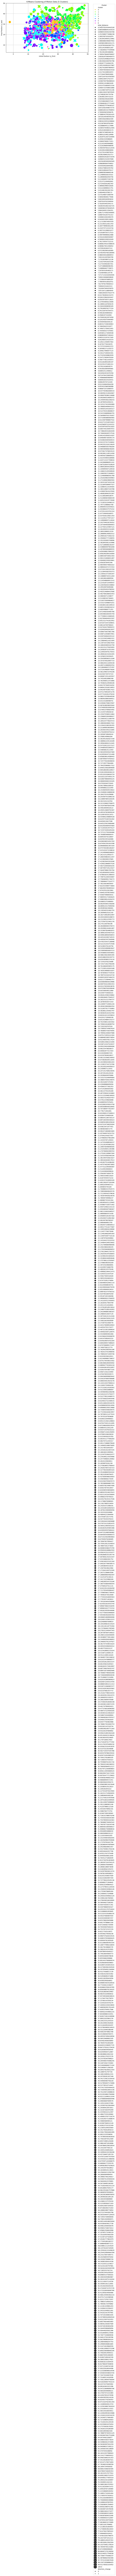

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette
palette = sns.color_palette("hsv", n_colors=7)

# Create the plot
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=final_df,
    x='y_first',  # Updated to y_first
    y='y_last',   # Updated to y_last
    hue='cluster', 
    palette=palette,
    style='direction_change',  # Different markers for direction change
    size='total_distance',     # Marker size reflects total distance
    sizes=(50, 500),           # Scale marker size between 50 and 500
    legend="full"
)

# Titles and labels
plt.title("K-Means Clustering of Motion Data (5 Clusters)")
plt.xlabel("Initial Position (y_first)")
plt.ylabel("Final Position (y_last)")
plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1))  # Adjust legend position
plt.grid(True)
plt.tight_layout()  # Ensure labels fit properly
plt.show()
